In [19]:
import torch
import numpy as np
import datasets
import os
import umap
import evaluate
import accelerate
import time
from pathlib import Path
from itertools import product
from IPython.core.debugger import set_trace
from datasets import Dataset, DatasetDict
from torch import nn
from torch.nn import functional as F
from sentence_transformers import SentenceTransformer
from nltk import sent_tokenize
from IPython.core.debugger import Pdb
from matplotlib import pyplot as plt
from transformers import AutoModel, AutoTokenizer
from pprint import pprint
from scipy.stats import spearmanr
from tqdm import tqdm
from multiprocessing import Pool
from itertools import chain
from numpy.lib.stride_tricks import sliding_window_view

from nbtools.sent_encoders.hf_models import from_hf
from nbtools.utils import (
    files,
    tensor_utils,
    display,
)
os.chdir('/data/john/projects/mltoolkit/')
cache_dir='./data/cache'
display.note(f'changed directory to \'{os.getcwd()}\'')

datasets.disable_caching()

# Set this to whatever you want
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline

[NOTE] changed directory to '/data/john/projects/mltoolkit'
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [2]:

"""
ds = datasets.load_dataset(
    'wikitext',
    'wikitext-103-raw-v1',
    cache_dir=cache_dir,
    trust_remote_code=True,
)
"""
ds = datasets.load_dataset(
    'wikipedia',
    '20220301.en',
    #language='en',
    #date='20240401',
    cache_dir=cache_dir,
    trust_remote_code=True,
)

print(ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 6458670
    })
})


In [5]:
num_proc = 10
#data = ds['train'][:]

def map_fn(x):
    return len(sent_tokenize(x['text']))

with Pool(num_proc) as p:
    counts = list(p.imap(
        map_fn,
        ds['train'],
    ))


1.0000
ratio of samples within limit: 0.9975
ratio of samples within limit: 1.0000
ratio of samples within limit: 1.0000
ratio of samples within limit: 1.0000
ratio of samples within limit: 1.0000


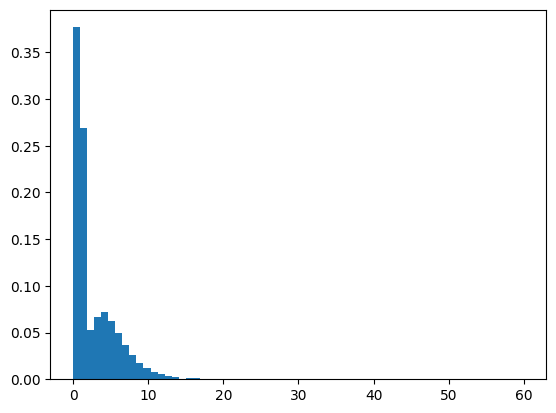

In [9]:
max_number = 64
sent_counts = np.array(counts)
#sent_counts = np.load('/data/john/files/wikipedia_sent_counts.npy')
sent_counts_filtered = sent_counts[sent_counts <= max_number]
print(f'{len(sent_counts_filtered) / len(sent_counts):.04f}')
_ = plt.hist(sent_counts_filtered, bins=max_number, density=True)

limits = np.array([16, 32, 64, 128, 256])
for limit in limits:
    print(f'ratio of samples within limit: {len(sent_counts[sent_counts <= limit])/len(sent_counts):.04f}')

# Notes from counting sentences

| $t$ | $\frac{1}{N}\sum\limits_{i}^{N} 1(\text{CountSents}(d_i) \leq t)$ |
| --- | ----------------------------------------------------------------- |
| $512$ | .9999                                                           |
| $256$ | .9946                                                           |
| $128$ | .9789                                                           |
| $64$  | .9350                                                           |


# Load Sentence Encoder

In [ ]:
model_name = 'mixedbread-ai/mxbai-embed-large-v1'
encoder = from_hf(
    model_name, 
    emb_dim=1024, 
    max_seq_len=512,
    cache_dir=cache_dir,
)

print(encoder)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)


# Convert to Embeddings

In [5]:
num_proc = 16

def map_fn(batch, rank, **fn_kwargs):

    # prepare documents
    doc_sents = [sent_tokenize(doc) for doc in batch['text']]
    lengths = [len(doc) for doc in doc_sents]
    indices = np.array(lengths).cumsum()[:-1]
    sents = list(chain.from_iterable(doc_sents))

    batch['sents'] = np.split(sents, indices)

    return batch


tds = ds.map(
    map_fn, 
    batched=True, 
    #batch_size=1024,
    batch_size=128,
    with_rank=True,
    num_proc=num_proc,
)

Map (num_proc=16): 100%|██████████| 6458670/6458670 [23:08<00:00, 4651.06 examples/s] 


In [25]:
def map_emb(batch, **fn_kwargs):

    lengths = [len(sents) for sents in batch['sents']]
    indices = np.array(lengths).cumsum()[:-1]
    sents = list(chain.from_iterable(batch['sents']))

    # compute embeddings
    start = time.time()
    pool = fn_kwargs['pool']
    embeddings = fn_kwargs['enc'].encode_multi_process(
        sents,
        batch_size=64,
        chunk_size=len(sents)//len(pool),
        pool=fn_kwargs['pool'],
    )
    end = time.time()
    print(f'encoding {len(sents)} sentences took {end-start} seconds')

    # add embeddings to batch
    batch['embeddings'] = np.split(embeddings, indices)

    return batch

try:
    encoder.stop_multi_process_pool(pool)
    print('stopped multiprocess pool')
except:
    print('failed to stop multiprocess pool')

model_name = 'mixedbread-ai/mxbai-embed-large-v1'
encoder = from_hf(
    model_name, 
    emb_dim=1024, 
    max_seq_len=512,
    cache_dir=cache_dir,
)

devs = [
    'cuda:1', 
    'cuda:2',
    'cuda:3',
]
pool = encoder.start_multi_process_pool(devs)

eds = tds.map(
    map_emb,
    batched=True,
    batch_size=1024,
    fn_kwargs={
        'enc': encoder,
        'pool': pool,
    }
)

stopped multiprocess pool


Map:   0%|          | 0/6458670 [00:00<?, ? examples/s]

encoding took -7.152557373046875e-07 seconds


Map:   0%|          | 1024/6458670 [05:43<601:13:52,  2.98 examples/s]


KeyboardInterrupt: 

In [12]:
eds.save_to_disk(f'{cache_dir}/wiki_embeddings')

Saving the dataset (1/1 shards): 100%|██████████| 3760/3760 [00:01<00:00, 2770.18 examples/s]


# Batch Size Timings

| N    | Time (hrs) |
| ---- | ---------- |
| 1024 | 428        |
| 2048 | 327        |